Divergences occur when price and your indicator move in opposite directions. For example, you’re trading with the RSI and it last had a peak at 80, now it peaks at 70. The underlying security you’re trading was at RM14 when RSI hit 80, and now hits a new peak at RM18. This is a divergence.

Traders will refer to the price as reaching a “higher high” and the RSI as a “lower high” because of the trend of the peaks. Technical traders track these visually — but it can be difficult to replicate because it isn’t always clear what exactly makes a “peak.” We provide an algorithmic way to detect peaks and troughs for trading, which we’ll leverage below as we get into the details of building an RSI divergence strategy.

### Divergences as Entry Signals
Divergences are often referred to as being either “bearish” or “bullish.” A bearish divergence is like the one we saw in the example above. We have a momentum indicator that is weakening ahead of the price which gives us a point to jump in and short it. A bullish divergence is where we have higher lows occurring for our momentum indicator, but lower lows in the price.

Under this interpretation, divergences are meant to be leading indicators — the divergence occurs before the price action confirms it. In practice, this is a bit more challenging to pull off because you find yourself looking for peaks in price and indicator, and a peak isn’t known to be a peak until some more time passes so you can see if the value decreases.

At any rate, let’s get to some code to illustrate how this works!

Detecting Divergences
The first step is going to require importing a few packages.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import argrelextrema
from collections import deque

If you follow this blog you’ll notice that there are a few extra we’re bringing in here. argrelextrema is used for detecting peaks in SciPy's signal processing library, and deque is like a fixed-length list that will drop the oldest entry and keep the new ones if you exceed its length. We'll use the first to spot our extrema in our data, then cycle through them and keep the points that are higher than the previous entries.

To spot our extrema, we need to pass an argument called order. This defines how many points on either side of our peak we need to actually label something a peak. So with order=5, we need something to be the highest point within 5-data points to the right and left. The other argument we provide is K, which is simply an integer to determine how many consecutive peaks we want to identify to determine a trend of higher highs.

The full, higher-high detection function is given below.



In [6]:
def getHigherLows(data: np.array, order=5, K=2):
    '''
    Finds consecutive higher lows in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive lows need to be higher.
    '''
    # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    # Ensure consecutive lows are higher than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] < lows[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema

def getLowerHighs(data: np.array, order=5, K=2):
    '''
    Finds consecutive lower highs in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive highs need to be lower.
    '''
    # Get highs
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
    # Ensure consecutive highs are lower than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] > highs[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

def getHigherHighs(data: np.array, order=5, K=2):
    '''
    Finds consecutive higher highs in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive highs need to be higher.
    '''
    # Get highs
    high_idx = argrelextrema(data, np.greater, order=5)[0]
    highs = data[high_idx]
    # Ensure consecutive highs are higher than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] < highs[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

def getLowerLows(data: np.array, order=5, K=2):
    '''
    Finds consecutive lower lows in price pattern.
    Must not be exceeded within the number of periods indicated by the width 
    parameter for the value to be confirmed.
    K determines how many consecutive lows need to be lower.
    '''
    # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    # Ensure consecutive lows are lower than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] > lows[i-1]:
            ex_deque.clear()

        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())

    return extrema

This returns a list of deques containing indices for our peaks. To get all of the relevant combinations for identifying divergences, we need four such functions one for higher highs (above), lower lows, lower highs, and higher lows. The logic for each of these is identical, we just change out np.greater for np.less in line 9 and change the inequality sign in line 18 to get the behavior we want. To keep things short, I'm not going to provide all the code in this post, but you can find each of these functions and additional explanations here.

We need some data, so we’ll pull that from the Yahoo! Finance API using the yfinance package. I'm going to use ExxonMobil (XOM) because it has seen a fair share of booms and busts over the past few decades, but most importantly, I just got gas there.



In [4]:
start = '2011-01-01'
end = '2011-07-31'
ticker = 'XOM'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)


Now we can calculate all of our extrema and plot the results.



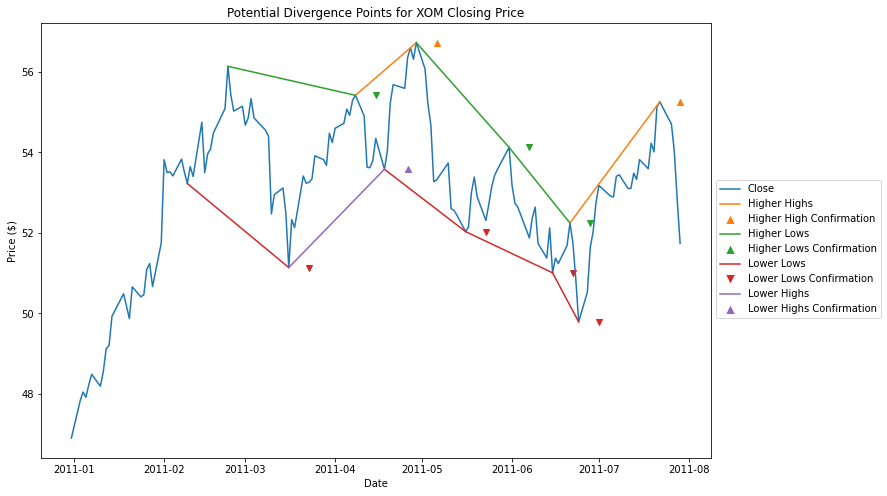

In [7]:
from matplotlib.lines import Line2D # For legend
price = data['Close'].values
dates = data.index
# Get higher highs, lower lows, etc.
order = 5
hh = getHigherHighs(price, order)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)
# Get confirmation indices
hh_idx = np.array([i[1] + order for i in hh])
lh_idx = np.array([i[1] + order for i in lh])
ll_idx = np.array([i[1] + order for i in ll])
hl_idx = np.array([i[1] + order for i in hl])
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.plot(data['Close'])
plt.scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
plt.scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
plt.scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
plt.scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [plt.plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [plt.plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], price[i], c=colors[4]) for i in hl]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.65))
plt.show()


In this plot, we pull out all of our potential divergence points and map the highs and lows to the price. Also, notice that I plotted confirmation points for each of the peaks. This goes back to that order value, we have no idea if a peak is actually a peak until we give it a few days (5, in this case) to see what the price does next.

The price chart is just half of what we need for divergences, we also need to apply an indicator. Drawing on Kauffman’s excellent Trading Systems and Methods, we ought to use some kind of momentum indicator. We’ll go ahead and apply the RSI, although the MACD, stochastics, and so forth, would be applicable as well.

### Peaks and Valleys of the RSI
The RSI is most frequently interpreted as showing upward momentum when the value is above the center line (RSI=50), and downward momentum when it is below the center line. If we have a series of smaller peaks above 50, it could indicate a reduction in momentum, and a series of increasing valleys below 50 could be a sign of increasing momentum that we could trade.

The next step for us then is to calculate the RSI, then apply the same technique as shown above to extract the relevant extrema. Code for the RSI is taken from this post if you’d like to get into the details and see some examples.



In [10]:
def calcRSI(data, P=14):
    data['diff_close'] = data['Close'] - data['Close'].shift(1)
    data['gain'] = np.where(data['diff_close']>0, data['diff_close'], 0)
    data['loss'] = np.where(data['diff_close']<0, np.abs(data['diff_close']), 0)
    data[['init_avg_gain', 'init_avg_loss']] = data[
    ['gain', 'loss']].rolling(P).mean()
    avg_gain = np.zeros(len(data))
    avg_loss = np.zeros(len(data))
    for i, _row in enumerate(data.iterrows()):
        row = _row[1]
        if i < P - 1:
            last_row = row.copy()
            continue
        elif i == P-1:
            avg_gain[i] += row['init_avg_gain']
            avg_loss[i] += row['init_avg_loss']
        else:
            avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
            avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P

        last_row = row.copy()

    data['avg_gain'] = avg_gain
    data['avg_loss'] = avg_loss
    data['RS'] = data['avg_gain'] / data['avg_loss']
    data['RSI'] = 100 - 100 / (1 + data['RS'])
    return data


With that function in place, we can the RSI and its related columns to our data frame with:



In [13]:
def getHHIndex(data: np.array, order=5, K=2):
    extrema = getHigherHighs(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
    extrema = getLowerHighs(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
    extrema = getLowerLows(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
    extrema = getHigherLows(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

In [14]:
data = calcRSI(data.copy())
rsi = data['RSI'].values
# Get values to mark RSI highs/lows and plot
rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)
# Get indices
rsi_hh_idx = getHHIndex(rsi, order)
rsi_lh_idx = getLHIndex(rsi, order)
rsi_ll_idx = getLLIndex(rsi, order)
rsi_hl_idx = getHLIndex(rsi, order)


We’ll follow the same format as above to plot our results:



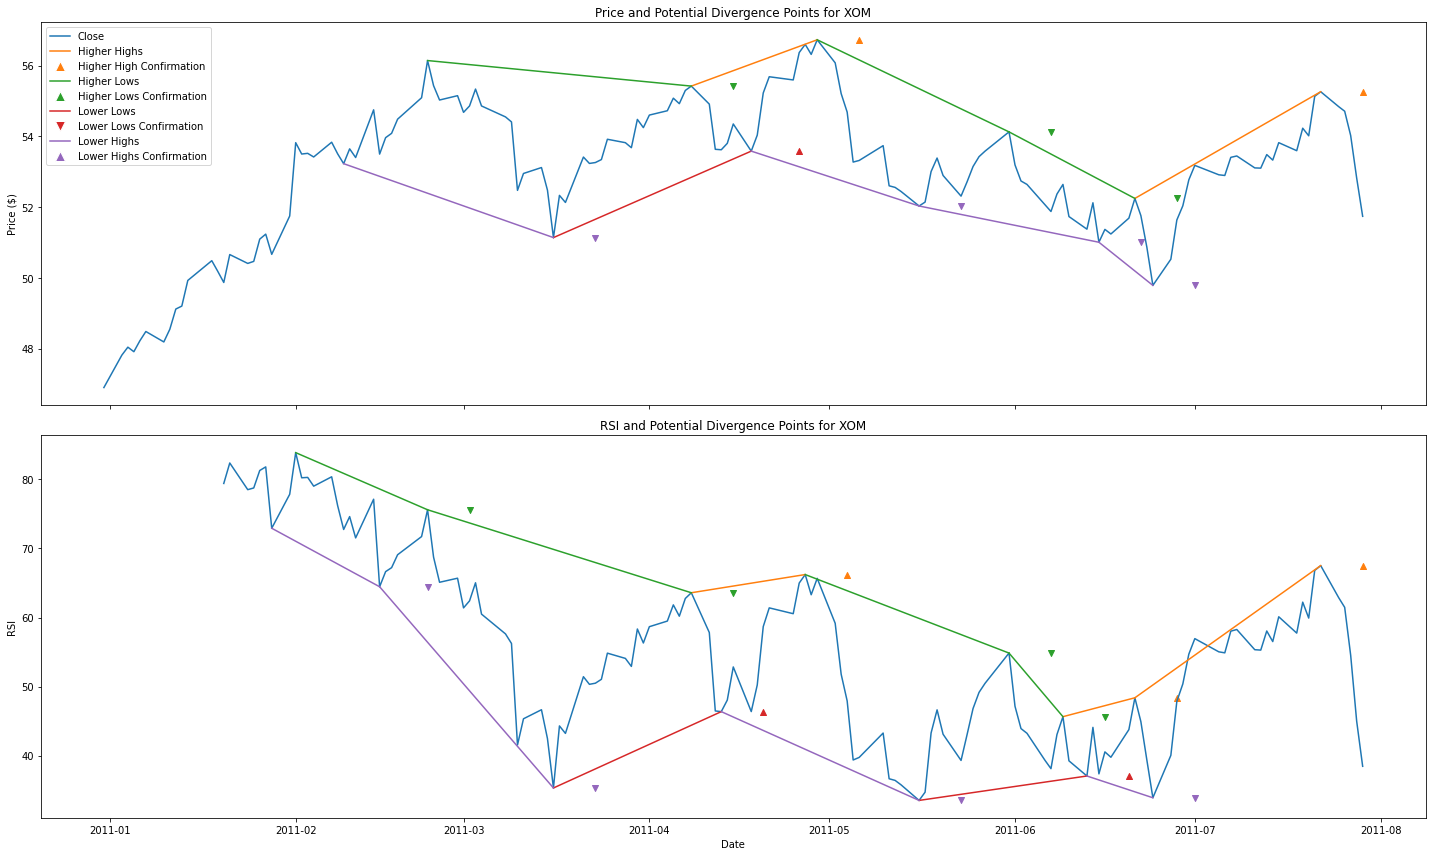

In [15]:
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(data['Close'])
ax[0].scatter(dates[hh_idx], price[hh_idx-order], 
              marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order],
              marker='v', c=colors[2])
ax[0].scatter(dates[hl_idx], price[hl_idx-order],
              marker='^', c=colors[3])
ax[0].scatter(dates[ll_idx], price[ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in hl]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in ll]
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'Price and Potential Divergence Points for {ticker}')
ax[0].legend(handles=legend_elements)
ax[1].plot(data['RSI'])
ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], 
              marker='^', c=colors[1])
ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order],
              marker='v', c=colors[2])
ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order],
              marker='^', c=colors[3])
ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_hl]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_ll]
ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for {ticker}')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()


This is only a short, 7-month window so we can clearly see the moves of both the price and RSI, so there is only one divergence visible. We see confirmation of higher lows in mid-June on the RSI chart (orange, upward pointing triangle) in the midst of a long series of lower lows in the price chart (blue, downward pointing triangles). We don’t trade off of charts, so let’s put an algorithm together to test this RSI divergence model.

### Building an RSI Divergence Model
So far we have some general rules for identifying cases where we have divergences, but we still need entry and exit rules. For starters, we can turn to Kaufmann’s excellent Trading Systems and Methods where he lays out an example strategy with the following rules:

Enter a position when the divergence has been identified if the indicator is above the target level (e.g. RSI = 50).
Exit if the indicator divergence disappears. If we short while the price makes a higher high and the RSI makes a lower high, then our RSI moves to a higher high, then we’re out.
Exit once the indicator has reached the target level.
Allow the divergence to convert to a trend position. For this, we use a separate trend indicator (e.g. EMA cross-over) and we hold the position if the trend is in the same direction as the divergence. If the divergence disappears but the trend continues we hold, and exit only when the trend disappears.
We’re going to build two models off of Kaufmann’s rules, one that is only trading the divergences (rules 1–3) and one that has divergence plus trend (all 4 rules). Of course, feel free to modify these as you see fit and experiment with a variety of approaches yourself.

Next, I’m going to build some helper functions to mark our peaks. The first set are going to modify the output of our getHigherHighs group of functions. These were built for the vizualizations above, but we just need to extract the confirmation points of the trends for our model. Also note that because we're adding order to our index, we could get confirmation points that will raise index errors, so we drop any indices that are greater than the number of data points we have.

The four functions are below:



In [16]:
def getHHIndex(data: np.array, order=5, K=2):
    extrema = getHigherHighs(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
    extrema = getLowerHighs(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
    extrema = getLowerLows(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
    extrema = getHigherLows(data, order, K)
    idx = np.array([i[-1] + order for i in extrema])
    return idx[np.where(idx<len(data))]

To reduce re-writing code, I’m going to introduce a function called getPeaks which takes our data frame and encodes the output of our highs and lows into column vectors. It will use the four functions we defined above and assign a value of 1 from the point we hit higher highs into the Close_highs column. If our highs are trending down after confirming a lower high, then we mark that with a -1 in the same column. It will do the same for the lows. It will be important to remember which values have a 1 and which have a -1, so I made it a 1 if the trend is increasing (higher highs or higher lows) and -1 if the trend is decreasing (lower highs or lower lows).



In [17]:
def getPeaks(data, key='Close', order=5, K=2):
    vals = data[key].values
    hh_idx = getHHIndex(vals, order, K)
    lh_idx = getLHIndex(vals, order, K)
    ll_idx = getLLIndex(vals, order, K)
    hl_idx = getHLIndex(vals, order, K)

    data[f'{key}_highs'] = np.nan
    data[f'{key}_highs'][hh_idx] = 1
    data[f'{key}_highs'][lh_idx] = -1
    data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
    data[f'{key}_lows'] = np.nan
    data[f'{key}_lows'][ll_idx] = 1
    data[f'{key}_lows'][hl_idx] = -1
    data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
    return data


Finally, we can build our strategy. Here, we’re just following the first 3 rules laid out above.



In [19]:
def RSIDivergenceStrategy(data, P=14, order=5, K=2):
    '''
    Go long/short on price and RSI divergence.
    - Long if price to lower low and RSI to higher low with RSI < 50
    - Short if price to higher high and RSI to lower high with RSI > 50
    Sell if divergence disappears.
    Sell if the RSI crosses the centerline.
    '''
    data = getPeaks(data, key='Close', order=order, K=K)
    data = calcRSI(data, P=P)
    data = getPeaks(data, key='RSI', order=order, K=K)

    position = np.zeros(data.shape[0])
    for i, (t, row) in enumerate(data.iterrows()):
        if np.isnan(row['RSI']):
            continue
        # If no position is on
        if position[i-1] == 0:
            # Buy if indicator to higher low and price to lower low
            if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
                if row['RSI'] < 50:
                    position[i] = 1
                    entry_rsi = row['RSI'].copy()
                    
            # Short if price to higher high and indicator to lower high
            elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
                if row['RSI'] > 50:
                    position[i] = -1
                    entry_rsi = row['RSI'].copy()

        # If current position is long
        elif position[i-1] == 1:
            if row['RSI'] < 50 and row['RSI'] < entry_rsi:
                position[i] = 1

        # If current position is short
        elif position[i-1] == -1:
            if row['RSI'] < 50 and row['RSI'] > entry_rsi:
                position[i] = -1

    data['position'] = position
    return calcReturns(data)

def calcReturns(df):
    # Helper function to avoid repeating too much code
    df['returns'] = df['Close'] / df['Close'].shift(1)
    df['log_returns'] = np.log(df['returns'])
    df['strat_returns'] = df['position'].shift(1) * df['returns']
    df['strat_log_returns'] = df['position'].shift(1) * df['log_returns']
    df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
    df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) - 1
    df['peak'] = df['cum_returns'].cummax()
    df['strat_peak'] = df['strat_cum_returns'].cummax()
    return df


One thing to note on the exit conditions, we’re to wait for a change in the trend. Rather than waiting for 5 days for a confirmation from a peak in the RSI, I added a condition that states if the RSI breaks below our entry RSI on a long position or above our entry RSI on a short position, we should get out. This works because if we short on a lower high in the RSI, then we’re going to exit if that reverses. If the RSI closes above our entry RSI, then either that becomes a higher high, thereby breaking our trend, or a higher high will still come. Putting this condition in just gets us out of the trade much more quickly.

Ok, enough explanation, let’s test it on data from 2000–2020 (also, we're grabbing our getStratStats function from here if you want to re-create this).



In [20]:
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (
        buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, 
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    
    return stats_dict


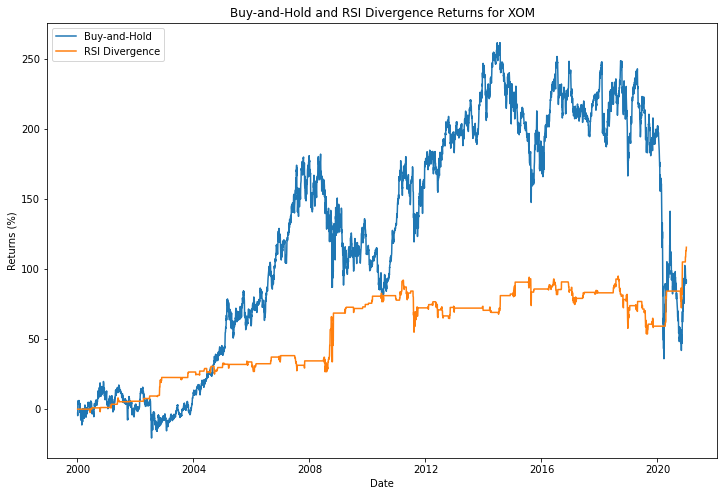

KeyError: 'strat_log_returns'

In [21]:
start = '2000-01-01'
end = '2020-12-31'
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

df_div = RSIDivergenceStrategy(data.copy())

plt.figure(figsize=(12, 8))
plt.plot(df_div['cum_returns'] * 100, label='Buy-and-Hold')
plt.plot(df_div['strat_cum_returns'] * 100, label='RSI Divergence')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title(f'Buy-and-Hold and RSI Divergence Returns for {ticker}')
plt.legend()
plt.show()
df_stats = pd.DataFrame(getStratStats(df_div['log_returns']), 
                        index=['Buy and Hold'])
df_stats = pd.concat([df_stats, 
                      pd.DataFrame(getStratStats(df_div['strat_log_returns']),
                                   index=['Divergence'])])
df_stats


In the end, the divergence strategy wound up outperforming a buy-and-hold approach (ignoring dividends, which Exxon does pay). It did so with less volatility and smaller drawdowns, but it did underperform from 2004–2020. In other words, you’d be waiting for 16 years with what looks like a losing strategy against the underlying before just breaking above in 2020. This strategy might work better elsewhere or fit into a diversified portfolio, but at least in this case, a pure RSI divergence strategy doesn’t look great.

### RSI Divergence and Trend
For this next model, let’s take Kaufman’s suggestion and apply a trend conversion. For this, we’re going to choose an EMA cross-over. So, the model will trade just like the divergence model we saw above, but will check the trend as indicated by our EMA cross-over. If we’re long and EMA1 > EMA2, we keep that position going.

Code for the EMA calculation and the strategy are given below:



In [22]:
def _calcEMA(P, last_ema, N):
  return (P - last_ema) * (2 / (N + 1)) + last_ema

def calcEMA(data, N):
  # Initialize series
  data['SMA_' + str(N)] = data['Close'].rolling(N).mean()
  ema = np.zeros(len(data))
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < N:
      ema[i] += row['SMA_' + str(N)]
    else:
      ema[i] += _calcEMA(row['Close'], ema[i-1], N)
  data['EMA_' + str(N)] = ema.copy()
  return data

def RSIDivergenceWithTrendStrategy(data, P=14, order=5, K=2, EMA1=50, EMA2=200):
  '''
  Go long/short on price and RSI divergence.
  - Long if price to lower low and RSI to higher low with RSI < 50
  - Short if price to higher high and RSI to lower high with RSI > 50
  Sell if divergence disappears or if the RSI crosses the centerline, unless
  there is a trend in the same direction.
  '''
  data = getPeaks(data, key='Close', order=order, K=K)
  data = calcRSI(data, P=P)
  data = getPeaks(data, key='RSI', order=order, K=K)
  data = calcEMA(data, EMA1)
  data = calcEMA(data, EMA2)
  position = np.zeros(data.shape[0])
  
  for i, (t, row) in enumerate(data.iterrows()):
    if np.isnan(row['RSI']):
      continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher high and price to lower high
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
      if row['RSI'] < 50 and row['RSI'] < entry_rsi:
        position[i] = 1
      elif row[f'EMA_{EMA1}'] > row[f'EMA_{EMA2}']:
        position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
      if row['RSI'] < 50 and row['RSI'] > entry_rsi:
        position[i] = -1
      elif row[f'EMA_{EMA1}'] < row[f'EMA_{EMA2}']:
        position[i] = -1

  data['position'] = position

  return calcReturns(data)


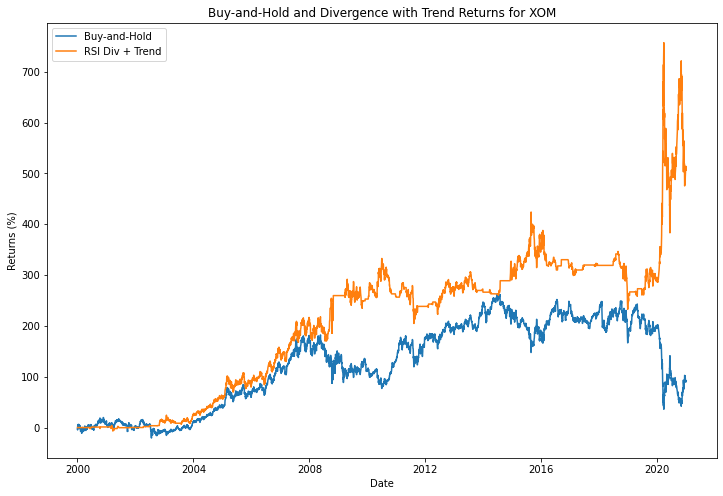

NameError: name 'df_stats' is not defined

In [24]:
df_trend = RSIDivergenceWithTrendStrategy(data.copy())
plt.figure(figsize=(12, 8))
plt.plot(df_trend['cum_returns'] * 100, label=f'Buy-and-Hold')
plt.plot(df_trend['strat_cum_returns'] * 100, label='RSI Div + Trend')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title(f'Buy-and-Hold and Divergence with Trend Returns for {ticker}')
plt.legend()
plt.show()

df_stats = pd.concat([df_stats, 
                      pd.DataFrame(getStratStats(df_trend['strat_log_returns']), 
                                   index=['Div + Trend'])])
df_stats
